# Road signs classifier

### 1. Download and check data¶

We will be using GTSRB data.
Available datasets are train and test. Instead of separating train data into train and validataion we will use test data for validation. This is possible, since there are ground truth labels available also for test data. 

In [1]:
%load_ext autoreload
%autoreload

In [2]:
%matplotlib inline

In [3]:
#uncomment the first time
#!wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_GT.zip -P source_data
#!wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_Images.zip -P source_data
#!wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip -P source_data

Unzip the data to source_data. This will overwrite existing files and directories.

In [4]:
#uncomment the first time

#!unzip -o source_data/GTSRB_Final_Test_GT.zip -d source_data/test
#!unzip -o source_data/GTSRB_Final_Test_Images.zip -d source_data/test
#!unzip -o source_data/GTSRB_Final_Training_Images.zip -d source_data/train

To verify the data we will create PyTorch dataset and DataLoader. 

In [5]:
import torch
from torchvision import datasets, transforms
#, models
#import torch.nn as nn
#from torch.nn import functional as F
#import torch.optim as optim

In [6]:
torch.__version__

'1.4.0'

GTSRB train data format is directly supported by pytorch generic data loader ImageFolder: https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder 

In [100]:
# Create Dataset

#Create Transforms

transform_train = transforms.Compose([
#    transforms.Resize((32, 32)),
    transforms.Resize(224),
    transforms.ToTensor(), 
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder('./source_data/train/GTSRB/Final_Training/Images', transform=transform_train)

# Load Datasets
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=128, shuffle=False, num_workers=2)

In [89]:
#Inspect classes
print(train_dataset.classes)

['00000', '00001', '00002', '00003', '00004', '00005', '00006', '00007', '00008', '00009', '00010', '00011', '00012', '00013', '00014', '00015', '00016', '00017', '00018', '00019', '00020', '00021', '00022', '00023', '00024', '00025', '00026', '00027', '00028', '00029', '00030', '00031', '00032', '00033', '00034', '00035', '00036', '00037', '00038', '00039', '00040', '00041', '00042']


In [90]:
#test train_dataset
assert len(train_dataset.classes) == 43, 'Incorrect number of classes, expected 43'
assert len(train_dataset) == 39209, 'Incorrect number of train files, expected 39209'
print('Train data loader correctly!')

Train data loader correctly!


GTSRB test data format is different: all image files are in one directory and there is a separate CSV file with ground truth labels, and some additinal features that we are not going to use.<br>

```csv
Filename;Width;Height;Roi.X1;Roi.Y1;Roi.X2;Roi.Y2;ClassId
00000.ppm;53;54;6;5;48;49;16
00001.ppm;42;45;5;5;36;40;1
00002.ppm;48;52;6;6;43;47;38
00003.ppm;27;29;5;5;22;24;33
00004.ppm;60;57;5;5;55;52;11
```
<br>
To load this data we will define a custom Dataset implementation iterating over the data, as defined in PyTorch Dataset documentation: https://pytorch.org/docs/stable/torchvision/datasets.html <br>

There is one more custom change required: test classes use 2 digit data format and train data use 5 digits: 000nn.<br>
We will use train data format: 000nn.

In [91]:
!pygmentize GTSRB_Test.py

import torch
import os
import pandas as pd
from torch.utils.data import Dataset
from PIL import Image

class GTSRB_Test(Dataset):
    
    def __init__(self, images_dir='./source_data/test/GTSRB/Final_Test/Images', 
                 gt_csv_path='./source_data/test/GT-final_test.csv', transform=None):
        """
        Args:
            images_dir (string): Path to GTSRB images directory
            gt_csv_path: path to test ground truth csv file
            transform (callable, optional): Optional transform to be applied

        Attributes:
            classes (list): List of the class names.
            class_to_idx (dict): Dict with items (class_name, class_index).    
            
        """
        self.images_dir = images_dir
        self.gt_csv_path = gt_csv_path

        self.gt_data = pd.read_csv(gt_csv_path, header=0, sep=';')
        self.gt_data['_000ClassId']=self.gt_data.ClassId.astype(str).str.zfill(5)
        self.transform = transform
        
        classes, class

In [92]:
from GTSRB_Test import GTSRB_Test 

# Create Transform 
transform_train = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(), 
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Create Dataset
validation_dataset = GTSRB_Test(
    images_dir  = './source_data/test/GTSRB/Final_Test/Images', 
    gt_csv_path = './source_data/test/GT-final_test.csv',
    transform = transform_train)

# Load Dataset
validation_dataloader = torch.utils.data.DataLoader(
    validation_dataset, batch_size=128, shuffle=False, num_workers=2)

In [93]:
#inspect classes
print(validation_dataset.classes)

['00000' '00001' '00002' '00003' '00004' '00005' '00006' '00007' '00008'
 '00009' '00010' '00011' '00012' '00013' '00014' '00015' '00016' '00017'
 '00018' '00019' '00020' '00021' '00022' '00023' '00024' '00025' '00026'
 '00027' '00028' '00029' '00030' '00031' '00032' '00033' '00034' '00035'
 '00036' '00037' '00038' '00039' '00040' '00041' '00042']


In [94]:
#test validation_dataset
assert len(validation_dataset) == 12630, 'Incorrect number of Validation files, expected 12630'
assert len(validation_dataset.class_to_idx) == 43, 'Incorrect number of classes, expected 43'
assert len(set(train_dataset.classes) & set(validation_dataset.classes)) == 43, 'Validation and train classes do not match' 

print('Validation data loaded correctly!')

Validation data loaded correctly!


### Visualize sample data¶

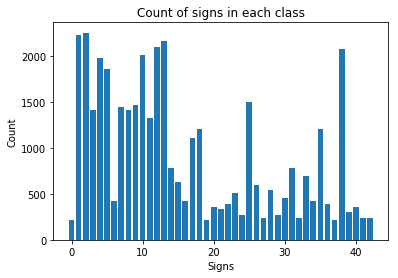

In [95]:
labels = np.zeros(len(train_dataset.classes))
for i in range(len(train_dataset)):
    x,y = train_dataset[i]
    labels[y] +=1
labels = np.array(labels, dtype=int)

classes = np.arange(len(labels))
plt.bar(classes, labels)
plt.xlabel('Signs')
plt.ylabel('Count')
plt.title('Count of signs in each class')
plt.show()

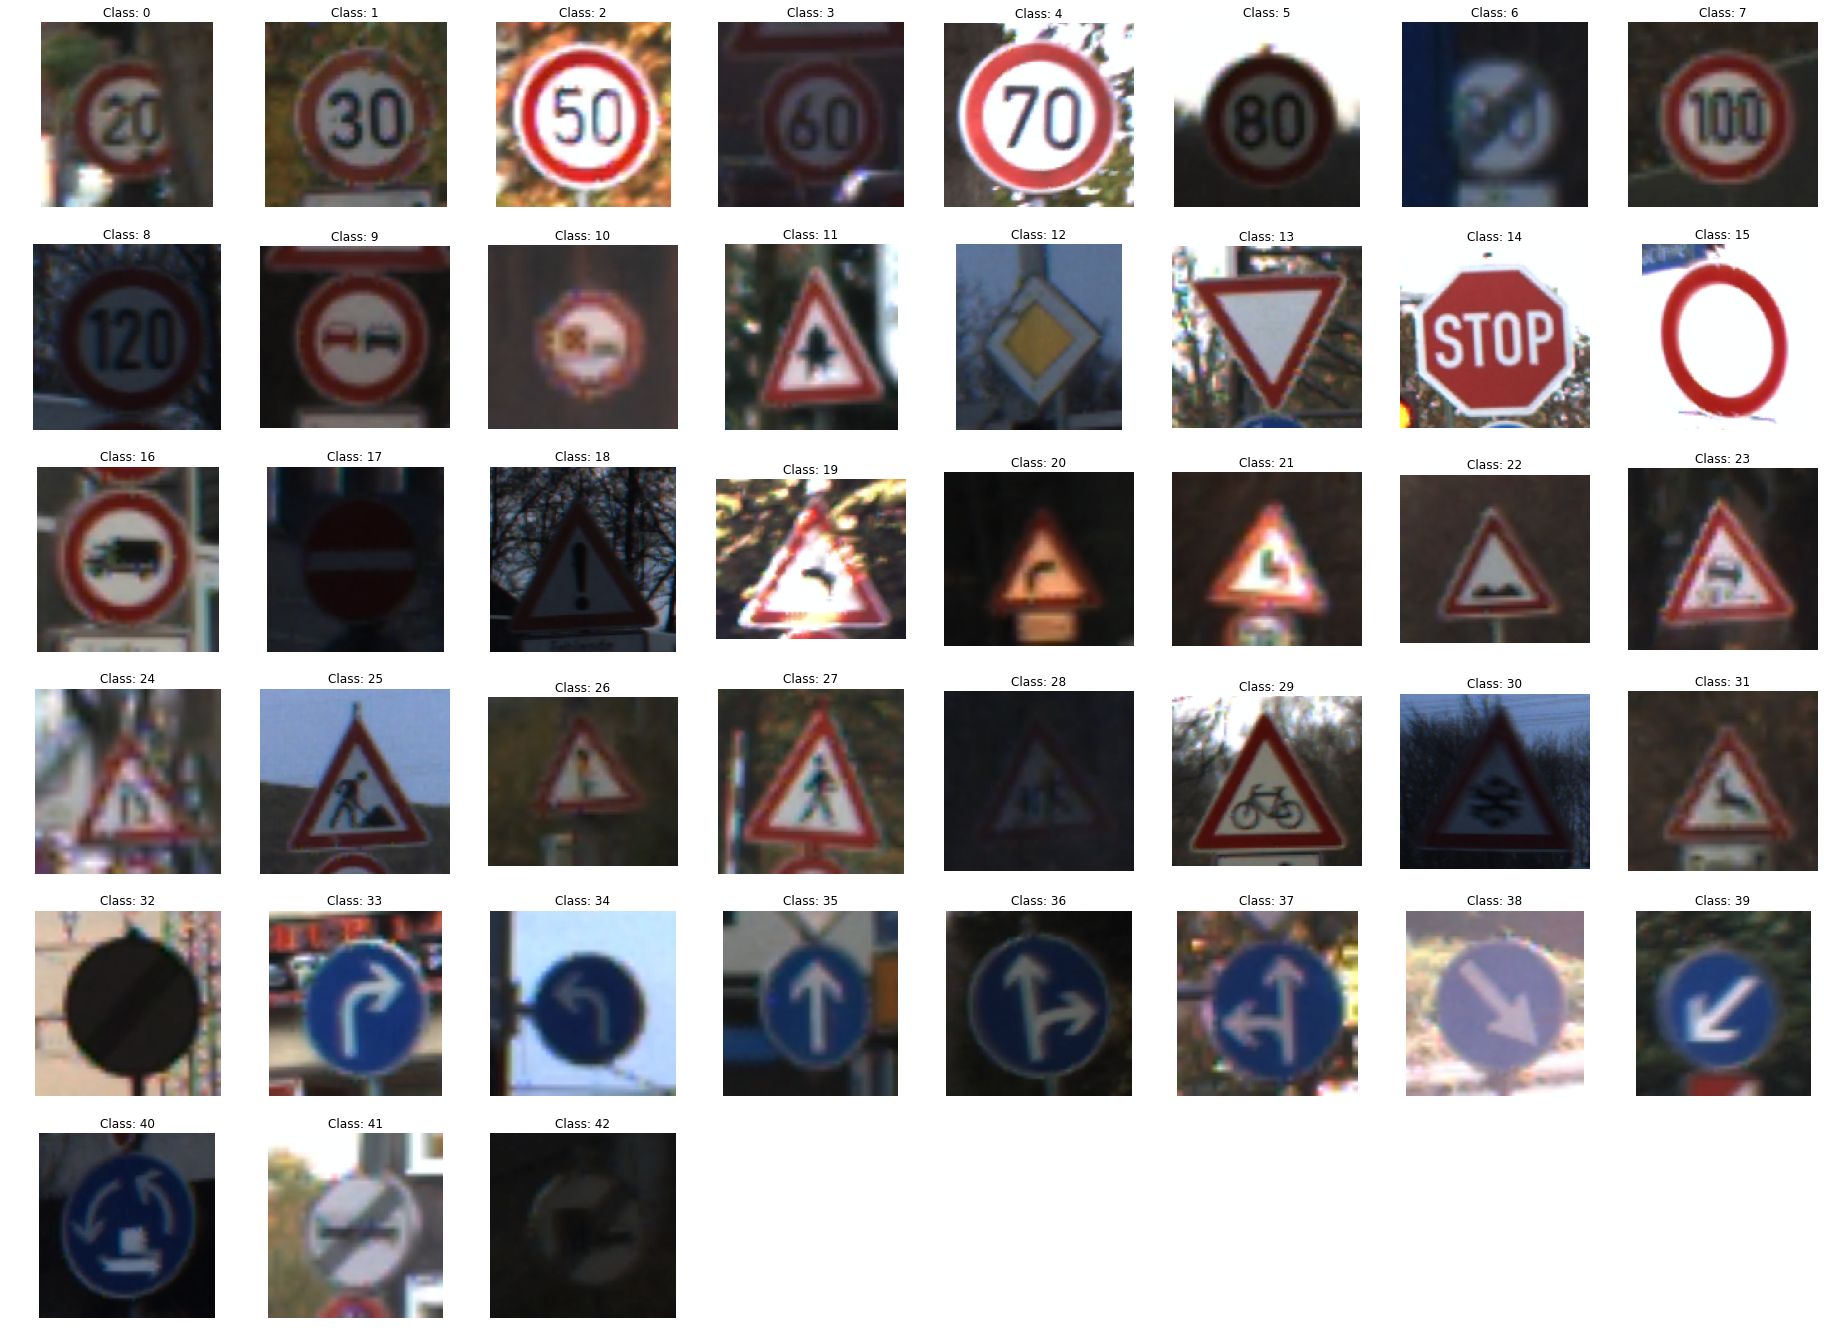

In [105]:
import random

plt.figure(figsize=(32, 32))
offset = 0
for classId in range(len(train_dataset.classes)):
    i = random.randint(0,labels[classId])
    #offset to the right class
    i = offset + i
    plt.subplot(8, 8, classId+1)
    plt.axis('off')
    plt.title('Class: {}'.format(classId))
    img, y = train_dataset[i]
    inp = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    #plt.imshow(np.transpose(img.numpy(), (1,2,0)), interpolation='nearest')
    offset += labels[classId]   